In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


alerts_df3 = pd.read_csv("./combined_status_tracker.csv")
#print(alerts_df3)

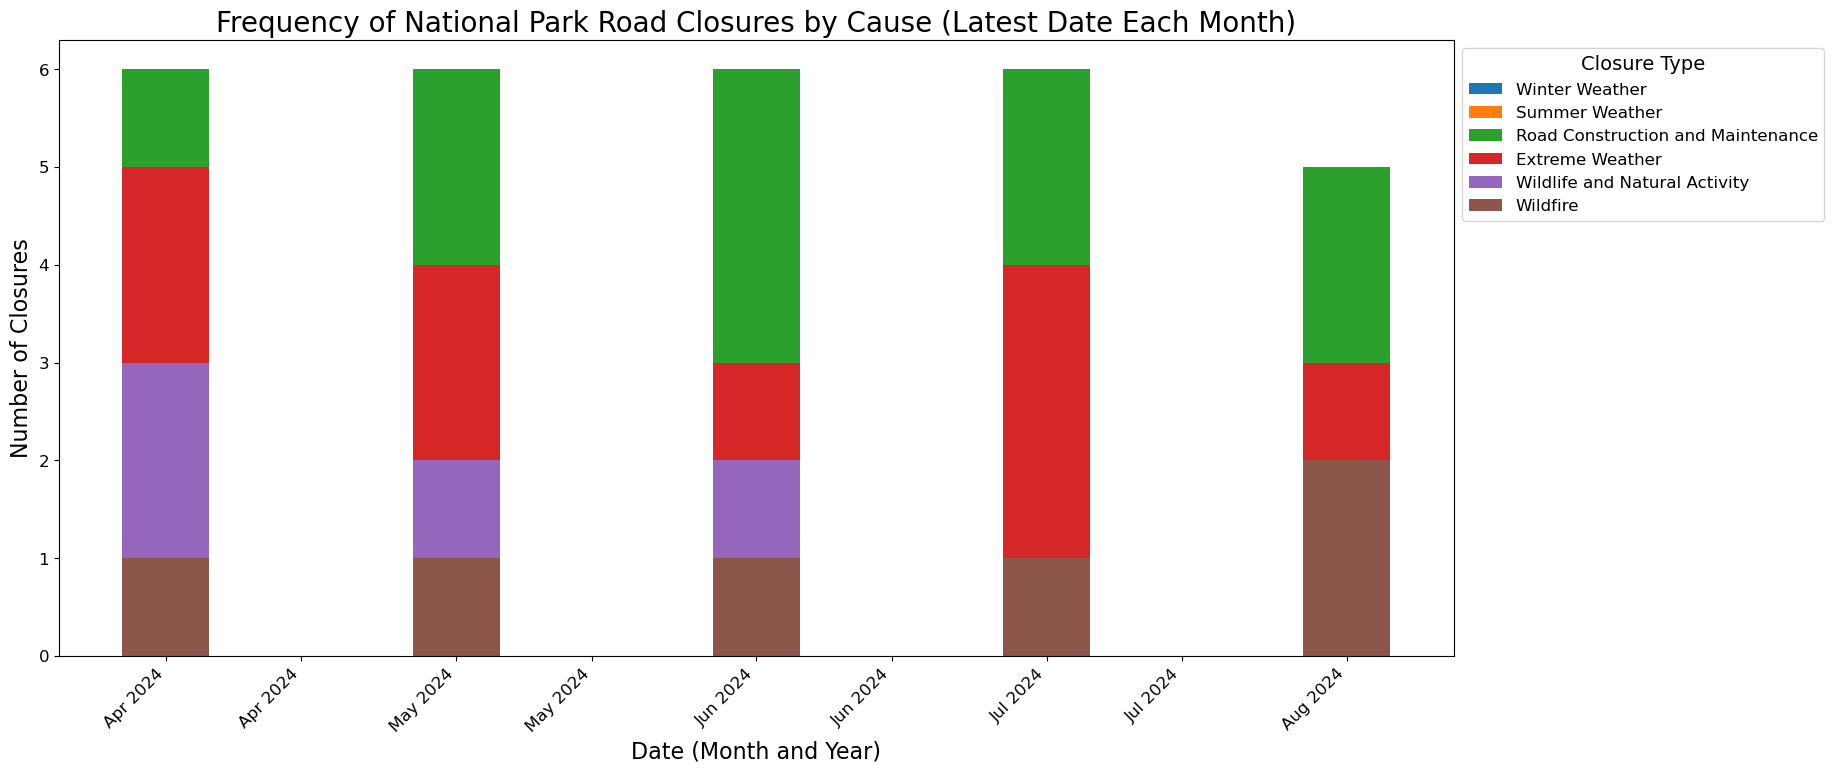

In [10]:
#Defining keywords to search
keyword_sets = {
    'Winter Weather': ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze'],
    'Summer Weather': ['heat', 'hot', 'humid', 'drought', 'sun', 'warm'],
    'Road Construction and Maintenance': ['construction', 'repair', 'paving', 'closure', 'detour', 'maintenance'],
    'Extreme Weather': ['storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake'],
    'Wildlife and Natural Activity': ['bear', 'deer', 'elk', 'bison', 'animal', 'wildlife'],
    'Wildfire': ['wildfire', 'fire']
}

# Ensure 'date' is in datetime format and reads all the various formats from the combined_status_tracker
alerts_df3['date'] = pd.to_datetime(alerts_df3['date'],format='mixed')

#Making the descriptions strings. This needs to be here because NaN descriptions are by default of type float
alerts_df3['description'] = alerts_df3['description'].astype(str).str.lower()

# Filter for the latest date in each month
alerts_df3['year_month'] = alerts_df3['date'].dt.to_period('M')
latest_dates = alerts_df3.groupby('year_month')['date'].max().reset_index()
filtered_df = pd.merge(alerts_df3, latest_dates, on='date')

#
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M').dt.to_timestamp()

grouped_df = filtered_df.groupby('month_year')['description'].apply(lambda x: ' '.join(x)).reset_index()

# Initialize a dictionary to store total frequencies for each keyword category
keyword_totals = {category: [] for category in keyword_sets}
keyword_totals['month_year'] = []


# Aggregate keyword counts across all regions
for month_year in sorted(filtered_df['month_year'].unique()):
    keyword_totals['month_year'].append(month_year)
    descriptions = ' '.join(filtered_df[filtered_df['month_year'] == month_year]['description'].str.lower())
    for category, keywords in keyword_sets.items():
        count = sum(1 for keyword in keywords if re.findall(keyword, descriptions))
        keyword_totals[category].append(count)

# Convert the keyword_totals dictionary to a DataFrame
keyword_df = pd.DataFrame(keyword_totals)

# Plotting the stacked bar chart
plt.figure(figsize=(18, 8))
for category in keyword_sets:
    plt.bar(keyword_df['month_year'], keyword_df[category], label=category, width=10)

#Format the x-axis labels
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

# Ensure y-axis only shows whole numbers
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Increase font sizes and update labels
plt.title('Frequency of National Park Road Closures by Cause (Latest Date Each Month)', fontsize=20)
plt.xlabel('Date (Month and Year)', fontsize=16)
plt.ylabel('Number of Closures', fontsize=16)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Closure Type', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1,1))

# Create the directories if they don't exist
output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'closure_types_over_time.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()
